In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import time
import copy

In [2]:
df = pd.read_pickle('dataset.pkl')

In [3]:
class Sample:
    
    """
    the Sample class is designed to easily visualize the 2D data under study and to handle all
    necessary operations to perform event reweight using event-by-event iterations and maximum factorization.
    """
    
    def __init__(self, bins, x_var, y_var, _df, flux_bins, mode_list, non_fact_par_list=None):
        
        """ 
        initializes all variables and runs all the necessary operations for the sample to be ready to be reweighted.
        """

        # variables for calculations
        self.df = _df                # the dataframe containing all the information in every event for the whole dataset
        self.bins = bins             # the list of 2D bins for our sample        
        self.flux_bins = flux_bins   # the list of flux bins to do flux reweight
        self.mode_list = mode_list   # the list of cross section modes that we want to reweight
        
        self.rw_idx = {}             # a map from every event index to its list of reweight indices
        self.reset_rw_idx()          # initialize self.rw_idx
        self.evts_to_bins = {}       # a dic from every event index to its bin index
        self.bins_to_evts = {}       # a dic from every bin index to the list of the event indeces contained on it
        self.nom_bin_cnts = {}       # a dic from every bin index to its nominal event rate count
        self.par_frac_per_bin = {}   # a dic from every bin to a dic of the unique indices and its corresponding event fractions
        self.uniq_par_idx     = {}   # a dic from every bin to the list of unique indices in that bin. This is used to iterate directly over this unique configurations.
        self.Npars        = {}       # the number of parameters involved in reweighting the sample
        
        self.non_fact_par_list = non_fact_par_list  # a list of all the non factorizable parameters
        self.non_fact_evt_idx  = {}  # a list of all the events affected by non factorizable parameters
        
        # variables for plotting
        self.x_var = x_var           # the name of the x variable in the pandas dataframe
        self.y_var = y_var           # the name of the y variable in the pandas dataframe
        self.x_name = None           # the name of the x label in the plot
        self.y_name = None           # the name of the y label in the plot
        self.hist_bins = None        # the bins that we use to visualize the 2D distribution
                                     # notice that this can not be self.bins because we are using an irregular binning
                                     # which is not straighforwardly compatible with plt.hist2d 
                                     # and in general it is better to use a finner binning that self.bins to better represent the details of the 2D distribution.

        
        # we do all operations internally to have things fully automated
        # although the list of steps would be analogous for any other problem the code below is only a minimal example
        # and therefore the functions below would need to be re-implemented depending on the use case. 
        
        self.calc_bin_cnts()         # we convert our list of 2D bins in a 1D array of bin indices
                                     # for each bin we calculate the nominal event rate and we store the result in a dictionary
                                     # we store the result in self.nom_bin_cnts
        
        self.find_flux_idx()         # we search for the flux index of every event and we add it to self.rw_idx
        self.find_mode_idx()         # we search for the cross section mode index of every event and we add it to self.rw_idx
        self.find_par_frac()         # to calculate the reweighted event rate using factorization, we need to calculate the fraction of events in each bin
                                     # that are associated to a unique parameter combination.
        
        self.find_uniq_par_idx()
        self.find_non_fact_events()
        
    def calc_bin_cnts(self):
        
        """ 
        calculates the counts in all 2D bins
        the implementation assumes that a 2D binning is given as an input
        if a binning of a different dimensionality needs to be used re-adapt the loop structure below
        also build the auixliary maps self.evts_to_bins and self.bins_to_evts
        """
        
        bin_cnts = {}
        evts_to_bins = {x:-999 for x in range(len(self.x_var))} 
        idx = 0
        for b in self.bins:
            for i in range(len(b[1])-1):
                x = b[0]
                y = b[1][i:i+2]

                cnt_bin_evts = 0
                for n_evt, evt in enumerate(zip(self.x_var,self.y_var)):
                    x_evt = evt[0]
                    y_evt = evt[1]
                    if x_evt > x[0] and x_evt < x[1] and y_evt > y[0] and y_evt < y[1]:
                        cnt_bin_evts+=1
                        evts_to_bins[n_evt] = idx
                        
                bin_cnts[idx] = cnt_bin_evts
                idx +=1
        
        self.nom_bin_cnts = bin_cnts
        self.evts_to_bins = evts_to_bins
            
        bins_to_evts = {}
        for key, value in evts_to_bins.items():
            if value != -999:
                bins_to_evts.setdefault(value, []).append(key)
        
        self.bins_to_evts = bins_to_evts

    def reset_rw_idx(self):  
        
        """ 
        resets or initializes self.rw_idx
        """ 
        
        for i in range(len(self.df.index)):
            self.rw_idx[i] = []      
    
    def find_uniq_sublists(self, thelist):

        unique_sublists = []
        sublist_counts = {}

        for sublist in thelist:
            sublist_tuple = tuple(sublist)
            if sublist_tuple not in sublist_counts:
                unique_sublists.append(sublist)
                sublist_counts[sublist_tuple] = 1
            else:
                sublist_counts[sublist_tuple] += 1
    
    
        return unique_sublists, [sublist_counts[tuple(sublist)] for sublist in unique_sublists]

    def find_flux_idx(self):
        
        """ 
        searches the flux index associated to each event and appends it to self.rw_idx
        """ 

        E_bins = [ [self.flux_bins[i],self.flux_bins[i+1]] for i in range(len(self.flux_bins)-1)]
        cnt = 0
        self.flux_idx_to_E_bin = {}
        for i,b in enumerate(E_bins):
            found = False
            for n_evt,E in enumerate(list(self.df.Enu_true)):
                if b[0]<=E and E<b[1]:
                    found = True
                    self.rw_idx[n_evt].append(cnt)
                    
            if found:
                self.flux_idx_to_E_bin[cnt] = b
                cnt +=1

    def find_mode_idx(self):
        
        """ 
        searches the cross section mode index associated to each event and appends it to self.rw_idx
        """
        
        offset = len(np.unique(list(self.rw_idx.values())))   # to avoid duplication of parameter indices we need to offset the mode indices.

        self.mode_to_mode_idx = {}
        self.mode_idx_to_mode = {}
        
        for i,x in enumerate(self.mode_list):
            self.mode_to_mode_idx[x] = i+offset
            self.mode_idx_to_mode[i+offset] = x
        
        for i,m in enumerate(list(self.df.Mode)):
            if m in self.mode_list:
                self.rw_idx[i].append(self.mode_to_mode_idx[m])  
            
        self.Npars = offset + len(self.mode_idx_to_mode.keys()) # let's store the number of unique parameter indices
    
    
    def find_par_frac(self):
        
        """ 
        calculates for every bin a dictionary that maps a tuple of unique parameter indices to the associated event fraction of the events
        in that bin that share those same unique parameter indices and stores the result in self.par_frac_per_bin
        """     

        rec_bin_idx = np.unique(list(self.bins_to_evts.keys()))

        par_frac_per_bin = {}
        #fact_par_frac_per_bin = {}
        for r_bin in rec_bin_idx:
            idxs, cnts = self.find_uniq_sublists([list(self.rw_idx[evt_idx]) for evt_idx in self.bins_to_evts[r_bin]])
            par_frac_per_bin[r_bin] = {tuple(i):c/np.sum(cnts) for i,c in zip(idxs,cnts)}

            #rm those entries with non-fact parameters!
            if self.non_fact_par_list:
                tmp_dic = {}
                for check_idx, check_cnt in list(par_frac_per_bin[r_bin].items()):
                    if len(list(set(check_idx) - set(self.non_fact_par_list))) == len(check_idx):
                        tmp_dic[check_idx] = check_cnt
                par_frac_per_bin[r_bin] = tmp_dic
            
#         self.par_frac_per_bin = par_frac_per_bin 
#         self.fact_par_frac_per_bin = fact_par_frac_per_bin
        self.par_frac_per_bin = par_frac_per_bin

    
    def find_uniq_par_idx(self):
        
        """ 
        calculates for every bin a list of all its unique parameter indices and stores it in self.uniq_par_idx
        """  
        
        tmp_dic = {}
        for x in list(self.par_frac_per_bin.values()):
            for y in list(x.keys()):
                if self.non_fact_par_list:
                    for z in y:
                        if z not in self.non_fact_par_list:
                            tmp_dic[y]=0
                else:
                    tmp_dic[y]=0

        self.uniq_par_idx = list(tmp_dic.keys())
        
    def find_non_fact_events(self):
        if not self.non_fact_par_list:
            return []

        non_fact_evt_idx = []
        for n_evt in list(self.evts_to_bins.keys()):
                for p in self.rw_idx[n_evt]:
                    if p in self.non_fact_par_list:
                        non_fact_evt_idx.append(n_evt)
                        
        self.non_fact_evt_idx = non_fact_evt_idx
    
    
    def reweight_by_evt(self, parameters):
        
        """ 
        calculates the reweighted event rate prediction without using factorization
        """      
        
        new_bin_cnts = copy.copy(self.nom_bin_cnts) 
        for n_evt, b_idx in list(self.evts_to_bins.items()):
            if b_idx != -999: # depending on the flux bining choice, some events might not be included in any bin.
                w = 1
                for par_idx in self.rw_idx[n_evt]:
                    w*=parameters[par_idx]

                # we substract nominal contribution '1' and add new contribution for this event 'w'.
                new_bin_cnts[b_idx] += w-1
            
        return new_bin_cnts

    
    def reweight_factorized(self,parameters):
        
        """ 
        calculates the reweighted event rate prediction using factorization
        """   
        
        new_bin_cnts = {}
        for b_idx in list(self.nom_bin_cnts.keys()):
            bin_w = 0
            uniq_idx_and_fraq = self.par_frac_per_bin[b_idx]

            for p_idx, fraq in uniq_idx_and_fraq.items():
                w = fraq
                for p in p_idx:
                    w*= parameters[p]
                bin_w += w
                        
            new_bin_cnts[b_idx] = self.nom_bin_cnts[b_idx]*bin_w

        return new_bin_cnts
    
    
    def generic_reweight(self, parameters):
        new_bin_cnts = self.reweight_factorized(parameters)
        
        for n_evt in self.non_fact_evt_idx:
            b_idx = self.evts_to_bins[n_evt]
            if b_idx != -999: 
                w = 1
                for par_idx in self.rw_idx[n_evt]:
                    w*=parameters[par_idx]

                new_bin_cnts[b_idx] += w

        return new_bin_cnts    
    
    
    def gen_toy_syst(self,Npars):
        
        """ 
        generates a toy variation including only a random systematic variation of the nominal counts
        """  
        
        rndm_pars = np.random.normal(1, 0.1, size=Npars)
        # systematic variations (assuming 0.1 uncorrelated std for all parameters)
        new_bin_cnts = self.generic_reweight(rndm_pars)
        
        return new_bin_cnts, rndm_pars
    

    def gen_toy_full(self,Npars):
        
        """ 
        generates a toy variation including random statistic and systematic variation of the nominal counts
        """  
        
        rndm_pars = np.random.normal(1, 0.1, size=Npars)
        # systematic variations (assuming 0.1 uncorrelated std for all parameters)
        new_bin_cnts = self.generic_reweight(rndm_pars)
        
        # statistical variations
        _cnts = {}
        for x in new_bin_cnts.keys():
            _cnts[x] = np.random.poisson(new_bin_cnts[x])

        return _cnts, rndm_pars


    def show(self, use_bins=True, saveas=None):

        """ 
        plots the sample and optionally overlays the bin edges and saves the image.
        """

        hist_bins = None
        if not self.hist_bins:
            hist_bins = self.bins
        else:
            hist_bins = self.hist_bins

        _ = plt.hist2d(self.x_var, self.y_var, bins=hist_bins, cmin=0.01, cmap='gnuplot', alpha=1)
        plt.colorbar()

        if use_bins == True:
            for b in self.bins:
                for i in range(len(b[1])-1):
                    x = b[0]
                    y = b[1][i:i+2]
                    
                    # Get the current y-axis limits
                    y_min, y_max = plt.ylim()

                    # Get the current y-axis limits
                    x_min, x_max = plt.xlim()

                    # Calculate the fractions of the plot height
                    ymin_fraction = (y[0] - y_min) / (y_max - y_min)
                    ymax_fraction = (y[1] - y_min) / (y_max - y_min)
                    
                    # Calculate the fractions of the plot height
                    xmin_fraction = (x[0] - x_min) / (x_max - x_min)
                    xmax_fraction = (x[1] - x_min) / (x_max - x_min)
                    
                    plt.axvline(x=x[0], ymin=ymin_fraction, ymax=ymax_fraction, color='cyan', linestyle='-')
                    plt.axvline(x=x[1], ymin=ymin_fraction, ymax=ymax_fraction, color='cyan', linestyle='-')
                    
                    plt.axhline(y=y[0], xmin=xmin_fraction, xmax=xmax_fraction, color='cyan', linestyle='-')
                    plt.axhline(y=y[1], xmin=xmin_fraction, xmax=xmax_fraction, color='cyan', linestyle='-')

        plt.gca().set_xlabel(self.x_name)
        plt.gca().set_ylabel(self.y_name)

        if saveas:
            plt.tight_layout()
            plt.savefig(saveas)
            
            
print('Ready!')

Ready!


In [4]:
eps = 0.01
reco_bins =[
    [[600.,2000], [-1,0.6]],
    [[800.,2000], [0.6, 0.8]],
    [[1200.,2000],[0.8, 0.9]],
    [[250.,400],   [-1,-0.5, -0.2]+list(np.arange(0,1+eps,0.1))],
    [[400.,500],   [-1]+list(np.arange(0.2,1+eps,0.1))],
    [[500.,600],   [-1]+list(np.arange(0.3,1+eps,0.1))],
    [[600.,700],   list(np.arange(0.6,1+eps,0.1))],
    [[700.,800],   list(np.arange(0.6,1+eps,0.1))],
    [[800.,900],   list(np.arange(0.8,1+eps,0.1))],
    [[900.,1000],  list(np.arange(0.8,1+eps,0.1))],
    [[1000.,1100], [0.8, 0.9,1]],
    [[1100.,1200], [0.8, 0.9,1]],
    [[1200.,1300], [0.9,1]],
    [[1300.,1400], [0.9,1]],
    [[1400.,1500], [0.9,1]],
    [[1500.,1600], [0.9,1]],
    [[1600.,1700], [0.9,1]],
    [[1700.,1800], [0.9,1]],
    [[1800.,1900], [0.9,1]],
    [[1900.,2000], [0.9,1]],
]

def print_bins(bins):
    N = 1  # Number of decimal figures
    idx = 0
    for b in bins:
        for i in range(len(b[1])-1):
            x = b[0]
            y = b[1][i:i+2]
            
            print("Bin ", idx, ":\t Momentum (GeV/c) [", f"{x[0]/1000:.{N}f}", f"{x[1]/1000:.{N}f}","]", "    Cos(Angle) [", f"{y[0]:.{N}f}", f"{y[1]:.{N}f}","]")
            idx+=1
            
    return idx

N_bins = print_bins(reco_bins)

Bin  0 :	 Momentum (GeV/c) [ 0.6 2.0 ]     Cos(Angle) [ -1.0 0.6 ]
Bin  1 :	 Momentum (GeV/c) [ 0.8 2.0 ]     Cos(Angle) [ 0.6 0.8 ]
Bin  2 :	 Momentum (GeV/c) [ 1.2 2.0 ]     Cos(Angle) [ 0.8 0.9 ]
Bin  3 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ -1.0 -0.5 ]
Bin  4 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ -0.5 -0.2 ]
Bin  5 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ -0.2 0.0 ]
Bin  6 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ 0.0 0.1 ]
Bin  7 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ 0.1 0.2 ]
Bin  8 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ 0.2 0.3 ]
Bin  9 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ 0.3 0.4 ]
Bin  10 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ 0.4 0.5 ]
Bin  11 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ 0.5 0.6 ]
Bin  12 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ 0.6 0.7 ]
Bin  13 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ 0.7 0.8 ]
Bin  14 :	 Momentum (GeV/c) [ 0.2 0.4 ]     Cos(Angle) [ 0.8 0.9 ]

In [5]:
def create_sample(df, fit_bins, nTest=0):
    
    x_var   = df.reco_mu_mom
    y_var   = df.CosLep    
    
    flux_bins = None
    xsec_modes = None
    non_fact_par_list = None
    
    if nTest == 0:    # only CCQE events wet weighted
        flux_bins =  []
        xsec_modes = [1]
    elif nTest == 1:  # only a few flux bins get weighted
        flux_bins =  list(np.linspace(0.25,1.8,3))+[30]
        xsec_modes = []
    elif nTest == 2: # a few flux bins and CCQE events get weighted
        flux_bins =  list(np.linspace(0.25,1.8,3))+[30]
        xsec_modes = [1]
    elif nTest == 3: # 10 flux bins and CCQE and 2p2h get weighted
        flux_bins = list(np.linspace(0.25,1.8,10))+[30]
        xsec_modes = [1,2]
    elif nTest == 4:            # 40 flux bins and all cross section modes get weighted (note that this is ~terrible for any fit, only a test to check speed comparison in reweight)
        flux_bins = list(np.linspace(0.25,1.8,40))+[30]
        xsec_modes = np.unique(list(df.Mode))
    elif nTest == 5:
        flux_bins = list(np.linspace(0.25,1.8,40))+[30]
        xsec_modes = np.unique(list(df.Mode))
        non_fact_par_list = [42]
    elif nTest == 6:
        flux_bins = list(np.linspace(0.25,1.8,40))+[30]
        xsec_modes = np.unique(list(df.Mode))
        non_fact_par_list = [41,42]
    else:
        print('Test', nTest, 'is not implemented!')
    
    s = Sample(fit_bins, x_var, y_var, df, flux_bins, xsec_modes, non_fact_par_list)
    s.x_name = 'reconstructed $p_\\mu$ [MeV/c] '
    s.y_name = 'reconstructed cos $\\theta$'
    s.hist_bins = [np.linspace(200,2000,100),np.linspace(-1,1,30)]
    
    return s

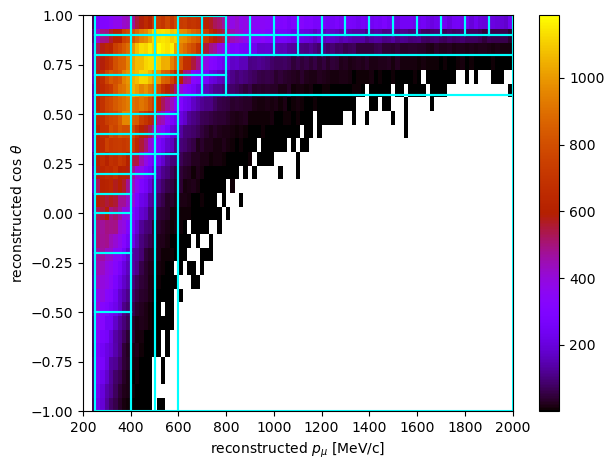

In [6]:
sample = create_sample(df, reco_bins)
sample.show(saveas='fitSample.pdf')

### check that both methods give same reweight results

In [7]:
def reweight_validation(s):
    # calculate the updated event rate for the two methods
    # method 1 with factorization
    # method 2 without factorization
    
    test_parameters = np.random.uniform(0.8, 1.2, size=s.Npars)
    
    wFact  = s.generic_reweight(test_parameters)
    woFact = s.reweight_by_evt(test_parameters)
    
    # check that the keys for both are the same
    print("The bin IDs are the same for both methods: ", list(wFact.keys()) == list(woFact.keys()))
    
    # check what is the difference in the predicted event rate (should be compatible with numerical precision < 1e-8)
    keys = wFact.keys()
    check_list = []
    for key in keys:
        check_list.append(abs(wFact[key] - woFact[key]) < 1e-8)

    # check that all of them are True
    print("The event rate is the same for all bins:   ", all(check_list))

In [8]:
reweight_validation(sample)

The bin IDs are the same for both methods:  True
The event rate is the same for all bins:    True


### check that time performance is as expected

In [9]:
def calc_f_time(f,params, num_loops=10):

    # List to store execution times
    execution_times = []

    for _ in range(num_loops):
        start_time = time.time()

        # Call your function here
        f(params)

        execution_time = time.time() - start_time
        execution_times.append(execution_time)

    # Calculate mean and standard deviation
    mu  = np.mean(execution_times)
    sd = np.std(execution_times)

    return mu, sd

def calc_bin_tot_conf(s):
    NbinConfTot=0
    for b_idx in list(s.nom_bin_cnts.keys()):
        uniq_idx_and_fraq = s.par_frac_per_bin[b_idx]
        NbinConfTot+=len(uniq_idx_and_fraq)

    return NbinConfTot

def calc_response_eval_woFact(s):
    nEval = 0
    for n_evt, b_idx in list(s.evts_to_bins.items()):
        if b_idx != -999:
            for par_idx in s.rw_idx[n_evt]:
                nEval +=1
                
    return nEval

In [10]:
uniq_indices   = []
bin_tot_conf   = []
nEval_woFact   = []
time_wFact_mu  = []
time_wFact_sd  = []
time_woFact_mu = []
time_woFact_sd = []

for i in range(5):
    
    test_sample = create_sample(df, reco_bins, nTest=i)
    test_parameters = np.random.uniform(0.8, 1.2, size=test_sample.Npars)
    
    print("--- Test ", i, "---")
    reweight_validation(test_sample)
    print("-------------------")
    
    uniq_indices.append(len(test_sample.uniq_par_idx))
    bin_tot_conf.append(calc_bin_tot_conf(test_sample))
    nEval_woFact.append(calc_response_eval_woFact(test_sample))
    
    mu1, sd1 = calc_f_time(test_sample.generic_reweight,test_parameters, 100)
    time_wFact_mu.append(mu1)
    time_wFact_sd.append(sd1)
    
    mu2, sd2 = calc_f_time(test_sample.reweight_by_evt,test_parameters,100)
    time_woFact_mu.append(mu2)
    time_woFact_sd.append(sd2)

--- Test  0 ---
The bin IDs are the same for both methods:  True
The event rate is the same for all bins:    True
-------------------
--- Test  1 ---
The bin IDs are the same for both methods:  True
The event rate is the same for all bins:    True
-------------------
--- Test  2 ---
The bin IDs are the same for both methods:  True
The event rate is the same for all bins:    True
-------------------
--- Test  3 ---
The bin IDs are the same for both methods:  True
The event rate is the same for all bins:    True
-------------------
--- Test  4 ---
The bin IDs are the same for both methods:  True
The event rate is the same for all bins:    True
-------------------


In [11]:
# results in LaTeX format
for i in range(5):
    print(i, '\t&',uniq_indices[i], '\t&', bin_tot_conf[i], '\t&', nEval_woFact[i], '\t&', f"{time_wFact_mu[i]*1e6:.{0}f}"+f" \\pm {time_wFact_sd[i]*1e6:.{0}f} \\textmu s", \
         '\t&', f"{time_woFact_mu[i]*1e3:.{0}f}"+f" \\pm {time_woFact_sd[i]*1e3:.{0}f} ms", '\t&', f"\\times {time_woFact_mu[i]/time_wFact_mu[i]:.{0}f}", "\\\\")

0 	& 2 	& 114 	& 200992 	& 52 \pm 4 \textmu s 	& 158 \pm 3 ms 	& \times 3035 \\
1 	& 3 	& 162 	& 285460 	& 73 \pm 14 \textmu s 	& 176 \pm 2 ms 	& \times 2418 \\
2 	& 6 	& 278 	& 486452 	& 114 \pm 12 \textmu s 	& 201 \pm 1 ms 	& \times 1766 \\
3 	& 29 	& 1027 	& 525824 	& 345 \pm 20 \textmu s 	& 204 \pm 2 ms 	& \times 591 \\
4 	& 308 	& 6394 	& 570920 	& 2235 \pm 37 \textmu s 	& 209 \pm 1 ms 	& \times 93 \\


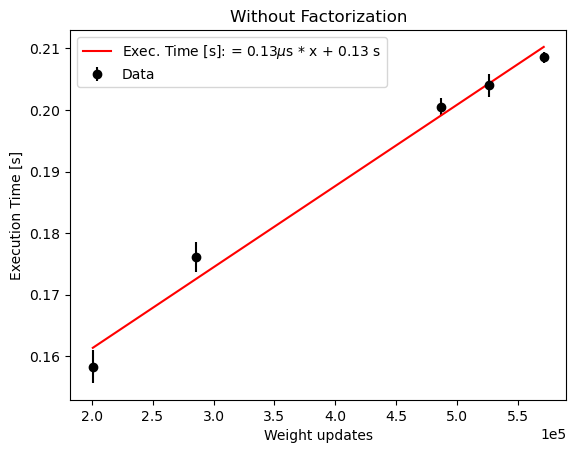

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Input data
x = np.array(nEval_woFact)
y = np.array(time_woFact_mu)
y_err = np.array(time_woFact_sd)
# Perform linear fit
slope, intercept = np.polyfit(x, y, 1)

# Generate predicted y values based on the linear fit
y_fit = slope * x + intercept

# Plot the original data and the linear fit
plt.errorbar(x, y, y_err, label='Data', c='k', fmt='o')# marker='s')
plt.plot(x, y_fit, color='red', label=f'Exec. Time [s]: = {slope*1e6:.2f}$\\mu$s * x + {intercept:.2f} s')

# Add labels and a legend
plt.xlabel('Weight updates')
plt.ylabel('Execution Time [s]')
plt.legend()

fmt=matplotlib.ticker.ScalarFormatter(useOffset=True)
fmt.set_scientific(True)
fmt.set_powerlimits((4, 5))

plt.gca().xaxis.set_major_formatter(fmt)

# Show the plot
#plt.show()
plt.title('Without Factorization')
plt.savefig('time_woFact.pdf')

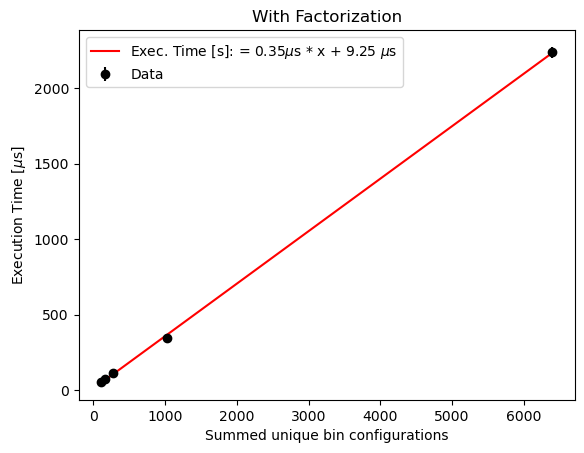

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Input data
x = np.array(bin_tot_conf)
y = np.array(time_wFact_mu)*1e6
y_err = np.array(time_wFact_sd)*1e6
# Perform linear fit
slope, intercept = np.polyfit(x, y, 1)

# Generate predicted y values based on the linear fit
y_fit = slope * x + intercept

# Plot the original data and the linear fit
plt.errorbar(x, y, y_err, label='Data', c='k', fmt='o')# marker='s')
plt.plot(x, y_fit, color='red', label=f'Exec. Time [s]: = {slope:.2f}$\\mu$s * x + {intercept:.2f} $\\mu$s')

# Add labels and a legend
plt.xlabel('Summed unique bin configurations')
plt.ylabel('Execution Time [$\\mu$s]')
plt.legend()

# Show the plot
plt.title('With Factorization')
plt.savefig('time_wFact.pdf')

### check that the hybrid case (w Fact and w/o Fact) also works and time is as expected

In [14]:
for i in [5,6]:

    sample = create_sample(df, reco_bins, nTest=i)
    test_parameters = np.random.uniform(0.8, 1.2, size=sample.Npars)
    mu1, sd1 = calc_f_time(sample.generic_reweight,test_parameters, 10)
    mu2, sd2 = calc_f_time(sample.reweight_by_evt,test_parameters,10)
    expected = len(sample.non_fact_evt_idx)/len(df.index)*mu2
    
    print("--- Test ", i, "---")
    print(f"Expected Time: {expected:.{3}f} +/-", f"{sd1:.{3}f} ms")
    print(f"Actual   Time: {mu1:.{3}f} +/-", f"{sd2:.{3}f} ms")
    print("-------------------")

--- Test  5 ---
Expected Time: 0.020 +/- 0.000 ms
Actual   Time: 0.019 +/- 0.000 ms
-------------------
--- Test  6 ---
Expected Time: 0.050 +/- 0.000 ms
Actual   Time: 0.039 +/- 0.001 ms
-------------------
